# 1. Descriptive analysis

In [1]:
import codecs
import io
import json
from multiprocessing import Pool
import os
import sys
import warnings
from traceback import format_exc

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import seaborn as sns
from sklearn.base import clone
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score,recall_score, precision_score, precision_recall_curve, roc_auc_score
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import pandas as pd
from patsy import dmatrices

warnings.filterwarnings("ignore")

sns.set(style = "ticks")
data_dir = "../data/"
input_dir = data_dir + "prediction_input/"
output_dir = data_dir + "simplified_prediction_output/"

## 1.1 Popularity of emojis

In [45]:
# The number of different emojis
actor_emojis_file = data_dir + "actor_emojis"
github_emoji_count = {}
with open(actor_emojis_file, "r") as f:
    for eachLine in f:
        jsonObj = json.loads(eachLine.strip())
        emojis = jsonObj["emojis"]
        for emoji in emojis:
            if emoji not in github_emoji_count:
                github_emoji_count[emoji] = 0
            github_emoji_count[emoji] += emojis[emoji]

github_emoji_count_sorted = sorted(github_emoji_count.items(), key = lambda x:x[1], reverse = True)
len(github_emoji_count_sorted)  

2699

In [46]:
# top 20 emojis on GitHub
emoji_top_20 = [x[0] for x in github_emoji_count_sorted[:20]]
" ".join(emoji_top_20)

'🚀 ✅ ⬆️ ☁️ 👍 ⬇️ 🎉 🌴 🎫 ✔️ ⚠️ ❌ ⌨️ 🚨 😄 ♻️ 📺 💛 ❤️ 🔥'

In [49]:
# mapping unqualified emoji to qualified emoji
mapping_file = data_dir + "emoji_duplicate_mapping"
with io.open(mapping_file, "rt", encoding = "utf8") as file:
    mapping_emojis = json.loads(file.read())

# emojis by post type on GitHub
post_emoji_file = data_dir + "2018_post_type_emojis"
with codecs.open(post_emoji_file, "r", "utf-8") as f:
    posttype_emoji_count = {}
    posttype_emoji_count_sorted = {}
    for eachLine in f:
        jsonObj = json.loads(eachLine.strip())
        post_type = jsonObj["post_type"]
        emojis = jsonObj["emojis"]
        emoji_count = {}
        for emoji_tuple in emojis:
            emoji = emoji_tuple[0]
            count = emoji_tuple[1]
            if emoji in mapping_emojis:
                emoji = mapping_emojis[emoji]
            if emoji not in emoji_count:
                emoji_count[emoji] = 0
            emoji_count[emoji] += count
        posttype_emoji_count[post_type] = emoji_count
        emoji_count_sorted = sorted(emoji_count.items(), key = lambda x: x[1], reverse = True)
        posttype_emoji_count_sorted[post_type] = emoji_count_sorted

# top 10 emojis in different posts
for key in posttype_emoji_count_sorted:
    emoji_count_sorted = posttype_emoji_count_sorted[key]
    print(key)
    selected = [x[0] for x in emoji_count_sorted[:10]]
    print(" ".join(selected))

issues_comment
👍 ⌨️ 😄 🎉 🚀 💪 😉 🚨 📺 ✨
issues
🚨 📺 ❌ ⚠️ ✔️ 🌴 👋 ✅ ⌨️ 👽
pull_review_comment
👍 😄 🤔 😉 ⚠️ 😅 🙂 😆 ✅ 💯
pull
☁️ 🎫 🚀 🌴 🎉 🚦 ♻️ 📅 🔕 🎟️
pull_comment
⬆️ 🚀 ✅ ⬇️ 👍 🎉 ✔️ ❌ ⚠️ 💛
commit_comment
✅ 📜 👍 🔥 💯 😄 🦍 🎉 🔴 ®️


In [50]:
type_posts = {}
post_file = data_dir + "2018_posttype_posts"

with open(post_file, "r") as f:
    for eachLine in f:
        jsonObj = json.loads(eachLine.strip())
        type_posts[jsonObj["post_type"]] = jsonObj["count"]

type_emojiposts = {}
post_file = data_dir + "2018_posttype_emojiposts"
with open(post_file, "r") as f:
    for eachLine in f:
        jsonObj = json.loads(eachLine.strip())
        type_emojiposts[jsonObj["post_type"]] = jsonObj["count"]
        
type_emojipost_per = {}
for post_type in type_posts:
    type_emojipost_per[post_type] = type_emojiposts[post_type] / type_posts[post_type]
print(type_posts)
print(type_emojipost_per)

{'issues': 9436402, 'issues_comment': 18485203, 'pull_review_comment': 8366087, 'commit_comment': 802005, 'pull_comment': 11898784, 'pull': 13863740}
{'issues': 0.03342174273626749, 'issues_comment': 0.03372205325524421, 'pull_review_comment': 0.02920254116410695, 'commit_comment': 0.060888647826385124, 'pull_comment': 0.14031240503231254, 'pull': 0.041403906882269866}


## 1.2 Emoji usage by programming languages

In [57]:
repo_lang_posts = {}
repo_lang_emojiposts = {}
lang_repos = {}

for posts, file_name in [(repo_lang_posts, "2018_repolang_posts"),
                         (repo_lang_emojiposts, "2018_repolang_emojiposts"),
                         (lang_repos, "2018_repolang_repos")]:
    with open(f"{data_dir}{file_name}") as f:
        for eachLine in f:
            jsonObj = json.loads(eachLine.strip())
            posts[jsonObj["repo_lang"]] = jsonObj["posts"] if "posts" in jsonObj else jsonObj["repos"]

lang_repos_sorted = sorted(lang_repos.items(), key = lambda x: x[1], reverse = True)
top_20_langs = []
for (lang, repos) in lang_repos_sorted[:22]:
    if lang == "null":
        continue
    if lang == None:
        continue
    top_20_langs.append(lang)

repo_lang_emojipost_per = {}
for lang in top_20_langs:
    repo_lang_emojipost_per[lang] = repo_lang_emojiposts[lang] / repo_lang_posts[lang]
    
print(top_20_langs)

['JavaScript', 'Python', 'Java', 'C++', 'Go', 'HTML', 'PHP', 'Ruby', 'TypeScript', 'C#', 'C', 'CSS', 'Shell', 'Rust', 'Scala', 'Swift', 'Objective-C', 'PowerShell', 'Jupyter Notebook', 'Kotlin']


In [58]:
repolang_emoji_count = {}
with open(f"{data_dir}2018_repolang_emojis", "r") as f:
    for eachLine in f:
        jsonObj = json.loads(eachLine.strip())
        lang_emojis = jsonObj["emojis"]
        emoji_count = {}
        for ele in lang_emojis:
            emoji = ele[0]
            if emoji in mapping_emojis:
                emoji = mapping_emojis[emoji]
            if emoji not in emoji_count:
                emoji_count[emoji] = 0
            emoji_count[emoji] += ele[1]
        repolang_emoji_count[jsonObj["repo_lang"]] = emoji_count

lang_emoji_type = {}
lang_emoji_entropy = {}
for lang in top_20_langs:
    emoji_count = repolang_emoji_count[lang]
    lang_emoji_type[lang] = len(emoji_count)
    count_list = list(emoji_count.values())
    lang_emoji_entropy[lang] = stats.entropy(count_list)
    print(lang + "\t" + str(len(emoji_count)) + "\t" + str(lang_emoji_entropy[lang]))

JavaScript	1854	3.9806464464050655
Python	1408	3.412641366349333
Java	1096	3.379612518194749
C++	1250	3.684146734416641
Go	891	3.3771118647958316
HTML	1593	3.727019593720316
PHP	1190	4.167697700610484
Ruby	1018	2.309964228357754
TypeScript	1001	3.3795817460585384
C#	800	3.458615485124416
C	717	3.6902110129637746
CSS	1154	4.144305775881677
Shell	778	4.335025945187563
Rust	606	3.573941308484075
Scala	635	2.7622115358799855
Swift	741	3.5504178758225224
Objective-C	523	3.466391727265569
PowerShell	341	1.085518427856564
Jupyter Notebook	388	3.4111302030444697
Kotlin	459	3.6030194996074627


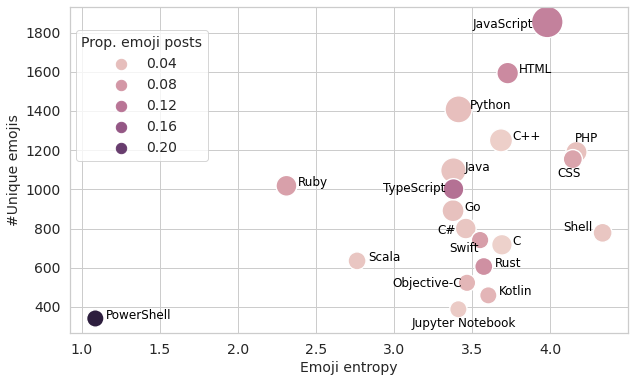

In [59]:
sns.set(style = "whitegrid")
plt.subplots(figsize=(10, 6))
plot_repos = []
plot_types = []
plot_entropy = []
plot_pers = []
for lang in top_20_langs:
    plot_repos.append(lang_repos[lang])
    plot_types.append(lang_emoji_type[lang])
    plot_entropy.append(lang_emoji_entropy[lang])
    plot_pers.append(repo_lang_emojipost_per[lang])
ax = sns.scatterplot(x = plot_entropy, y = plot_types, size = plot_repos, hue = plot_pers, sizes=(300, 1000), legend = "brief")#, style = plot_repos)

for i in range(0, 20):
    if top_20_langs[i] == "JavaScript":
        ax.text(plot_entropy[i] - 0.48, plot_types[i] - 30, top_20_langs[i], horizontalalignment="left", size="medium", color="black")
        continue
    if top_20_langs[i] == "PHP":
        ax.text(plot_entropy[i] - 0.01, plot_types[i] + 50, top_20_langs[i], horizontalalignment="left", size="medium", color="black")
        continue
    if top_20_langs[i] == "CSS":
        ax.text(plot_entropy[i] - 0.1, plot_types[i] - 90, top_20_langs[i], horizontalalignment="left", size="medium", color="black")
        continue
    if top_20_langs[i] == "Shell":
        ax.text(plot_entropy[i] - 0.25, plot_types[i] + 10, top_20_langs[i], horizontalalignment="left", size="medium", color="black")
        continue
    if top_20_langs[i] == "C#":
        ax.text(plot_entropy[i] - 0.18, plot_types[i] - 30, top_20_langs[i], horizontalalignment="left", size="medium", color="black")
        continue
    if top_20_langs[i] == "Swift":
        ax.text(plot_entropy[i] - 0.2, plot_types[i] - 60, top_20_langs[i], horizontalalignment="left", size="medium", color="black")
        continue
    if top_20_langs[i] == "Objective-C":
        ax.text(plot_entropy[i] - 0.48, plot_types[i] - 20, top_20_langs[i], horizontalalignment="left", size="medium", color="black")
        continue
    if top_20_langs[i] == "Jupyter Notebook":
        ax.text(plot_entropy[i] - 0.3, plot_types[i] - 90, top_20_langs[i], horizontalalignment="left", size="medium", color="black")
        continue
    if top_20_langs[i] == "TypeScript":
        ax.text(plot_entropy[i] - 0.45, plot_types[i] - 15, top_20_langs[i], horizontalalignment="left", size="medium", color="black")
        continue
    ax.text(plot_entropy[i] + 0.07, plot_types[i], top_20_langs[i], horizontalalignment="left", size="medium", color="black")#, weight="semibold"

handles, labels = ax.get_legend_handles_labels()
handles = handles[:5]
labels = labels[:5]
for h in handles:
    sizes = [s * 3 for s in h.get_sizes()]
    h.set_sizes(sizes)
ax.legend(handles, labels, bbox_to_anchor=(0.26, 0.95), title="Prop. emoji posts", fontsize = 14, title_fontsize = 14)

ax.set_xticklabels(ax.get_xticks(), size = 14)
yticks = [int(i) for i in ax.get_yticks()]
ax.set_yticklabels(yticks, size = 14)

plt.xlabel("Emoji entropy", fontsize = 14)
plt.ylabel("#Unique emojis", fontsize = 14)
plt.savefig("../visualization/" + "emoji_langs.png", dpi = 300)

# 2. Regression

In [69]:
feature_file = data_dir + "2018_emoji_and_non_emoji_user_features"
df1 = pd.read_csv(feature_file + "_p1", sep = "\t", header = 0)
df2 = pd.read_csv(feature_file + "_p2", sep = "\t", header = 0)
df3 = pd.read_csv(feature_file + "_p3", sep = "\t", header = 0)
df = pd.concat([df1, df2, df3])
df = df.rename(columns={"C++": "Cpp", "C#": "C_Sharp", "Objective-C": "Objective_C", "GCC Machine Description": "GCC", "Jupyter Notebook": "Jupyter_Notebook"})
df.head()

,actor_id,all_events,PullRequestProp,IssuesProp,CommentProp,PushProp,all_events_trend,working_days,working_days_trend,avg_hours_daily,...,C,CSS,PowerShell,Shell,Swift,Objective_C,GCC,Jupyter_Notebook,Rust,Scala
0,8227320,155,0.096774,0.116129,0.174194,0.335484,-1,63,-1,1.412698,...,0,0,0,0,0,0,0,0,0,0
1,823643,11,0.090909,0.000000,0.363636,0.272727,-1,6,-1,1.333333,...,0,0,0,0,0,0,0,0,0,0
2,5576409,832,0.043269,0.176683,0.191106,0.407452,-1,138,-1,2.231884,...,0,0,0,0,0,0,0,0,0,0
3,11144180,349,0.163324,0.051576,0.077364,0.398281,-1,121,-1,1.537190,...,0,0,0,0,0,0,0,0,0,0
4,2230599,5970,0.128308,0.096315,0.509380,0.290955,-1,332,-1,5.554217,...,0,0,0,0,0,0,0,0,0,0


In [74]:
post_types = ["issues", "issues_comment", "pull", "pull_comment", "commit_comment", "pull_review_comment"]
df["posts"] = sum(df[post] for post in post_types)
for post_type in post_types:
    df[f"{post_type}_per"] = df[post_type] / df["posts"]
df["emoji_post_prop"] = df["emoji_posts"] / df["posts"]

for feature_name in ["all_events", "n_seg", "n_seg_multi", "posts", "working_days", "platform_age", "emoji_posts"]:
    df[f"{feature_name}_log"] = np.log(df[feature_name] + 1)

In [75]:
productivity = ["all_events_log", "working_days_log", "avg_hours_daily", "avg_seg_hour", "n_seg_log", 
                "n_seg_multi_log", "posts_log", "gap1", "gap2", "gap4", "gap8", "gap16", "gap32", "gap64", "gap128", "gap256"]
trends_of_productivity = ["all_events_trend", "working_days_trend", "avg_hours_daily_trend", "avg_seg_trend", 
                          "n_seg_trend", "n_seg_multi_trend", "post_trend",]
type_of_work = ["PullRequestProp", "IssuesProp", "CommentProp", "PushProp", "PullRequestDayProp", "IssuesDayProp", 
                "CommentDayProp", "PushDayProp", "PullRequestSegProp", "IssuesSegProp", "CommentSegProp", "PushSegProp",]
type_of_communication = ["issues_per", "pull_per", "issues_comment_per", "pull_comment_per", "commit_comment_per", "pull_review_comment_per"]
time_management = ["weekday_entropy", "hours_entropy"]

column_names = list(df.columns)
background = ["platform_age_log"] + column_names[45:65]
feature_sets = [productivity, trends_of_productivity, type_of_work, type_of_communication, time_management, background]

all_feature = productivity + trends_of_productivity + type_of_work + type_of_communication + time_management + background
len(all_feature)

64

## 2.1 Outcome variable: emoji posts

In [66]:
%%time 

# the general VIF process: feature selection
# http://rstudio-pubs-static.s3.amazonaws.com/19354_8a4bf0895a5a4ecba74c55817b68f0a5.html
feature_columns = []
for feature_set in feature_sets:
    feature_columns += feature_set

def copy_list(alist):
    blist = []
    for i in alist:
        blist.append(i)
    return blist
    
drop = True
YY = "emoji_post_prop"

while drop:
    df1 = df[feature_columns + [YY]]
    features = "+".join(feature_columns)

    # get y and X dataframes based on this regression:
    y, X = dmatrices(YY + " ~" + features, df1, return_type="dataframe")    
    vif_list = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    vif = pd.DataFrame()
    columns_list = X.columns
    vif["VIF Factor"] = vif_list
    vif["features"] = columns_list

    vif_max = float(max(vif_list))
    if vif_max > 5.0:
        feature_to_remove = columns_list[vif_list.index(vif_max)]
        if feature_to_remove == "Intercept":           
            vif_list_2 = copy_list(vif_list)
            vif_list_2.remove(vif_max)
            vif_max = float(max(vif_list_2))
            if vif_max <= 5.0:
                drop = False
            else:
                feature_to_remove = columns_list[vif_list.index(vif_max)]
        feature_columns.remove(feature_to_remove)
        
print(feature_to_remove)

Intercept
CPU times: user 4h 47min 55s, sys: 2h 16min 40s, total: 7h 4min 35s
Wall time: 45min 19s


In [68]:
y = df[YY]
feature_columns_for_use = feature_columns
selected_features = []
results = []
for feature_set in feature_sets:
    selected_features += list(set(feature_set) & set(feature_columns_for_use))
    df_chosen = df[selected_features]
    X = df_chosen
    X2 = sm.add_constant(X)
    model = sm.OLS(y, X2)
    result = model.fit()
    print(result.summary())
    results.append(result)

dfoutput = summary_col(results, stars = True)
print(dfoutput)

                            OLS Regression Results                            
Dep. Variable:        emoji_post_prop   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1081.
Date:                Sun, 29 Jan 2023   Prob (F-statistic):               0.00
Time:                        11:27:03   Log-Likelihood:                 62001.
No. Observations:              529616   AIC:                        -1.240e+05
Df Residuals:                  529607   BIC:                        -1.239e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5533      0.031     

## 2.2 Outcome variable: prop. emotional emojis

In [69]:
df_emoji = df.loc[df.emoji_posts > 0]
df_ee = pd.read_csv(data_dir + "2018_emoji_user_emotional_emoji", sep = "\t", header = 0)
df_emoji_ee = df_emoji.join(df_ee.set_index("actor_id"), on = "actor_id")

In [72]:
%%time

feature_columns = []
for feature_set in feature_sets:
    feature_columns += feature_set

def copy_list(alist):
    blist = []
    for i in alist:
        blist.append(i)
    return blist
    
drop = True
YY = "prop_emotional_emoji"
while drop:
    df1 = df_emoji_ee[feature_columns + [YY]]
    features = "+".join(feature_columns)

    # get y and X dataframes based on this regression:
    y, X = dmatrices(YY + " ~" + features, df1, return_type="dataframe")    
    vif_list = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    vif = pd.DataFrame()
    columns_list = X.columns
    vif["VIF Factor"] = vif_list
    vif["features"] = columns_list
    # print(vif.round(1))
    
    vif_max = float(max(vif_list))
    
    if vif_max > 5.0:
        feature_to_remove = columns_list[vif_list.index(vif_max)]
        if feature_to_remove == "Intercept":           
            vif_list_2 = copy_list(vif_list)
            vif_list_2.remove(vif_max)
            vif_max = float(max(vif_list_2))
            if vif_max <= 5.0:
                drop = False
            else:
                feature_to_remove = columns_list[vif_list.index(vif_max)]
        feature_columns.remove(feature_to_remove)

feature_to_remove

CPU times: user 2h 33min 20s, sys: 1h 47min 12s, total: 4h 20min 32s
Wall time: 22min


'Intercept'

In [73]:
# after VIF in general
y = df_emoji_ee[YY]
feature_columns_for_use = feature_columns
selected_features = []
results = []
for feature_set in feature_sets:
    selected_features += list(set(feature_set) & set(feature_columns_for_use))
    df_chosen = df_emoji_ee[selected_features]
    X = df_chosen
    X2 = sm.add_constant(X)
    model = sm.OLS(y, X2)
    result = model.fit()
    print(result.summary())
    results.append(result)

dfoutput = summary_col(results, stars = True)
print(dfoutput)

                             OLS Regression Results                             
Dep. Variable:     prop_emotional_emoji   R-squared:                       0.006
Model:                              OLS   Adj. R-squared:                  0.006
Method:                   Least Squares   F-statistic:                     189.9
Date:                  Sun, 29 Jan 2023   Prob (F-statistic):               0.00
Time:                          12:43:00   Log-Likelihood:            -1.4680e+05
No. Observations:                264808   AIC:                         2.936e+05
Df Residuals:                    264798   BIC:                         2.937e+05
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.

# 3. Prediction

## 3.1 Model training

In [5]:
models = {
    "SVM": SVC(kernel="rbf", C=1),
    "GBDT": GradientBoostingClassifier(
        max_depth=5, max_features="sqrt", n_estimators=125
    ),
    "Logistic": LogisticRegression(max_iter=1000),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(10, 30, 10),
        alpha=0.001,
        learning_rate="adaptive",
        max_iter=1000,
    ),
}

In [37]:
def train_model(df_ds, selected_columns):
    X, y = df_ds[selected_columns], df_ds["dropout"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model_accuracies = {}
    model_aucs = {}
    model_pred_probs = {}
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        if model_name == "SVM":
            y_pred_prob = model.decision_function(X_test_scaled).round(4)
        else:
            y_pred_prob = model.predict_proba(X_test_scaled)[:, 1].round(4)
        model_pred_probs[model_name] = list(y_pred_prob)
        model_aucs[model_name] = roc_auc_score(y_test, y_pred_prob)
        model_accuracies[model_name] = accuracy_score(y_test, y_pred)
        model_pred_probs["gt"] = list(y_test) #ground truth
    return model_accuracies, model_aucs, model_pred_probs

In [10]:
%%time
measure_activity_levels = {"hour": [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                           "day": [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]}

def train_and_predict(measure: str, level: float):
    try:
        fouts = [open(f"{output_dir}/{measure}_{metric}_{level}", "w", buffering=1) 
                for metric in ["accuracies", "auc", "pred"]]
        for i in range(6):  # 6 folds training
            df_ds = list()
            for j in range(5):
                df_path = f"{input_dir}/{measure}_dropout_{level}_{i * 5 + j}"
                df_ds.append(pd.read_csv(df_path, dtype={"lang": "string"}, sep="\t", header=0))
            df_ds = pd.concat(df_ds)
            selected_columns = list(df_ds.columns)[1:-1]
            for fout, model_metric in zip(fouts, train_model(df_ds, selected_columns)):
                fout.write(f"{level}\t{i}\t{json.dumps(model_metric)}\n")
        for fout in fouts:
            fout.close()
    except Exception:
        print(f"Train and predict error {format_exc()}")
        
with Pool(processes=15) as pool:
    for measure, levels in measure_activity_levels.items():
        for level in levels:
            pool.apply_async(train_and_predict, args=(measure, level))
    pool.close()
    pool.join()

for metric in ["accuracies", "auc", "pred"]:
    for measure, levels in measure_activity_levels.items():
        with open(f"{output_dir}/{measure}_{metric}", "w") as fout:
            for level in levels:
                with open(f"{output_dir}/{measure}_{metric}_{level}", "r") as fin:
                    fout.write(fin.read())
                os.remove(f"{output_dir}/{measure}_{metric}_{level}")



CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 7.87 µs


## 3.2 Model performance

In [103]:
def get_prediction_results(measure):
    level_model_accuracies = {}
    with open(f"{output_dir}/{measure}_accuracies") as f:
        for eachLine in f:
            words = eachLine.strip().split("\t")
            level = float(words[0])
            if level not in level_model_accuracies:
                level_model_accuracies[level] = {}
            i = int(words[1]) #dataset index
            if i not in level_model_accuracies[level]:
                level_model_accuracies[level][i] = {}
            model_accuracies = json.loads(words[2])
            for key in model_accuracies:
                level_model_accuracies[level][i][key] = model_accuracies[key]
    
    level_model_auc = {}
    with open(f"{output_dir}/{measure}_auc") as f:
        for eachLine in f:
            words = eachLine.strip().split("\t")
            level = float(words[0])
            if level not in level_model_auc:
                level_model_auc[level] = {}
            i = int(words[1])
            if i not in level_model_auc[level]:
                level_model_auc[level][i] = {}
            model_auc = json.loads(words[2])
            for key in model_auc:
                level_model_auc[level][i][key] = model_auc[key]

    return level_model_accuracies, level_model_auc

def load_metrics(measure: str) -> pd.DataFrame:
    accuracies, auc = get_prediction_results(measure)
    models = ["GBDT", "Logistic", "SVM", "MLP"]
    levels, accs, aucs, models = list(), list(), list(), list()
    for level in measure_activity_levels[measure]:
        for i in range(6):
            for model, acc in accuracies[level][i].items():
                models.append(model)
                accs.append(acc)
                levels.append(int(level * 100))
                aucs.append(auc[level][i][model])
    return pd.DataFrame({"level": levels, "accuracy": accs, "auc": aucs, "Model": models})

def plot_metric(df: pd.DataFrame, measure: str, metric: str, fig_size=(5, 3)):
    plt.figure(figsize=fig_size)
    ax = sns.lineplot(
        data=df,
        x="level", y=metric, hue="Model", style ="Model",
        markers=True, dashes=False, ci=95
    )
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

    x_label = f"Top k% active (by avg. working {measure})"
    y_label = metric
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"../visualization/{measure}_{metric}.png", dpi=300)

### 3.2.1 Prediction results by avg. daily working hours

,level,accuracy,auc
Model,,,
GBDT,5.0,0.792,0.868
Logistic,5.0,0.740,0.817
MLP,5.0,0.784,0.856
SVM,5.0,0.757,0.831


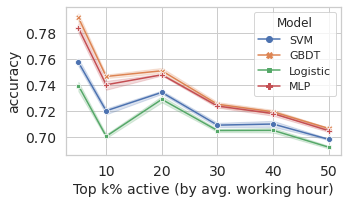

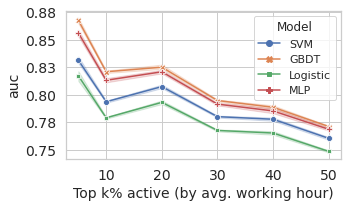

In [104]:
df_hour = load_metrics("hour")
plot_metric(df_hour, "hour", "accuracy")
plot_metric(df_hour, "hour", "auc")
df_hour[df_hour["level"]==5].groupby(["Model"]).mean().round(3)

### 3.2.2. Prediction results by #working days

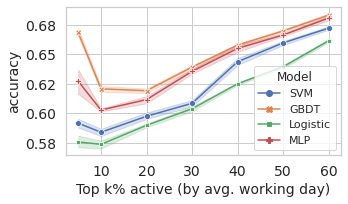

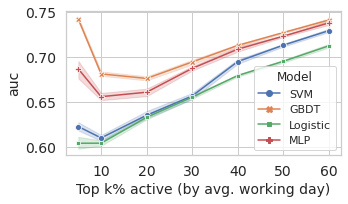

In [105]:
df_day = load_metrics("day")
plot_metric(df_day, "day", "accuracy")
plot_metric(df_day, "day", "auc")

#### 3.2.2.1 Precision and recall curve

In [4]:
level_idx_model_prob = {}
level_idx_gt_prob = {}
with open(f"{output_dir}/day_pred", "r") as f:
    for eachLine in f:
        words = eachLine.strip().split("\t")
        level = float(words[0])
        if level not in level_idx_model_prob:
            level_idx_model_prob[level] = {}
            level_idx_gt_prob[level] = {}
        i = int(words[1])
        if i not in level_idx_model_prob[level]:
            level_idx_model_prob[level][i] = {}
            level_idx_gt_prob[level][i] = {}
        model_pred_probs = json.loads(words[2])
        level_idx_model_prob[level][i]["GBDT"] = model_pred_probs["GBDT"]
        level_idx_gt_prob[level][i]["GBDT"] = model_pred_probs["gt"]

In [5]:
level = 0.05
precision_all = []
recall_all = []
for idx in range(6):
    y_true = np.array(level_idx_gt_prob[level][idx]["GBDT"])
    y_scores = np.array(level_idx_model_prob[level][idx]["GBDT"])
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    precision_all += list(precision)
    recall_all += list(recall)

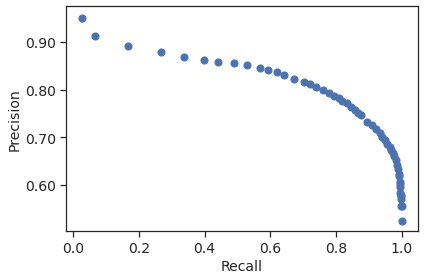

In [6]:
ax = sns.regplot(x=recall_all, y=precision_all, x_bins=60, fit_reg=False)
ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
x_label = "Recall"
y_label = "Precision"
plt.xlabel(x_label, fontsize=14)
plt.ylabel(y_label, fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("../visualization/day_precision_recall_binned_curve.png", dpi=300)

## 3.3 Model interpretation

### 3.3.1 Feature importance and coefficients

In [109]:
df_ds = list()
for i in range(5):
    df_path = f"{input_dir}/hour_dropout_0.1_3"
    df_ds.append(pd.read_csv(df_path, dtype={"lang": "string"}, sep="\t", header=0))
df_ds = pd.concat(df_ds)
selected_columns=list(df_ds.columns)[1:-1]
X, y = df_ds[selected_columns], df_ds["dropout"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=0)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_features = pd.DataFrame({"feature": selected_columns})
logistic = clone(models["Logistic"]).fit(X_train_scaled, y_train)
df_features["coef"] = list(list(logistic.coef_)[0])
gbdt = clone(models["GBDT"]).fit(X_train_scaled, y_train)
df_features["importance"] = list(gbdt.feature_importances_)
df_features = df_features.rename(columns={"coef": "coef", "importance": "importance"}).sort_values(by="importance", ascending=False).reset_index(drop=True)
df_draw = df_features.head(20)

In [110]:
feature_name_to_labels = {"emoji_post_prop": "prop. emoji posts", "all_emojis_log": "#emojis (log)", 
                          "emoji_entropy": "entropy of emojis", "emoji_post_log": "#emoji posts (log)",
                          "emoji_types_log": "#unique emojis (log)", "emoji_days_log": "#days using emoji (log)",
                          "posemo": "score of positive emotion", "sad": "score of sadness", "anx": "score of anxiety",
                          "negemo": "score of negative emotion", "anger": "score of anger", 
                          "emoji_d": "score of depression", "prop_emotional_emoji": "prop. emotional emojis"}
def get_feature_label(name):
    if name in feature_name_to_labels:
        return feature_name_to_labels[name]
    else:
        if name[0] == "e":
            return "%"
        else:
            return name

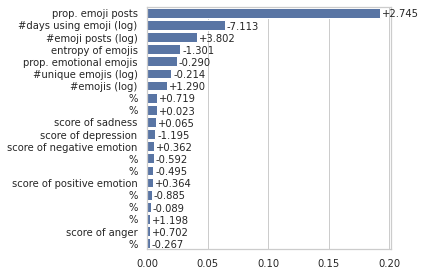

In [111]:
plt.figure(figsize = (6, 4))
feature_labels = []
feature_labels = [get_feature_label(name) for name in df_draw["feature"]]

ims = df_draw["importance"].values.tolist()
colors = [1 if c >= 0 else 0 for c in df_draw["importance"]]
ax = sns.barplot(x = "importance", y = "feature", data = df_draw, hue = colors, palette=sns.color_palette(), dodge=False)

# annotating the bars with coefficient begins
i = 0
coefs = df_draw["coef"].values.tolist()
for p in ax.patches:
    coef = df_draw["coef"].iloc[i]
    i += 1
    if coef < 0:
        ax.annotate("%.3f" % coef, xy=(p.get_width() - 0.005, p.get_y() + p.get_height() / 2 + 0.1),
                xytext=(5, 0), textcoords="offset points", ha="left", va="center", fontsize = 10)
    else:
        ax.annotate("+" + "%.3f" % coef, xy=(p.get_width() - 0.005, p.get_y() + p.get_height() / 2 + 0.1),
                xytext=(5, 0), textcoords="offset points", ha="left", va="center", fontsize = 10)

# annotating the bars with coefficient ends
ax.set_yticklabels(labels = feature_labels, size = 10)#, rotation = 60
xticks = ["%.2f" % x for x in ax.get_xticks()]
ax.set_xticklabels(xticks, size = 10)
ax.get_legend().remove()
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.savefig("../visualization/avg_hours_daily_feature.pdf", dpi = 300)

### 3.3.2 Correlations between features and dropouts

In [112]:
sns.set(style="whitegrid")

df_active_emoji = pd.read_csv(f"{data_dir}/active_emoji_users_0.1", sep="\t", header=0)
df_active_non_emoji = pd.read_csv(f"{data_dir}/active_non_emoji_users_0.1", sep="\t",  header=0)

for column in ["emoji_post_log", "emoji_post_prop", "emoji_entropy", "anger"]:
    df_active_non_emoji[column] = 0

xname_label = {"emoji_post_log": "#Emoji posts (log)", "emoji_post_prop": "Prop. emoji posts",
               "anger": "Score of angry emotion from emojis",
               "emoji_entropy": "Entropy of emojis", "posemo": "Score of positive emotion from emojis",
               "emoji_d": "Score of depression from emojis", "e54p": "Emoji: party popper",
               "anx": "Score of anxiety from emojis", "emoji_days_log": "#Days using emoji",
               "negemo": "Score of negative emotion from emojis", "e20p": "Emoji: thumbs up",
               "e63p": "Emoji: waving hand"}
yname="dropout"
y_label="Dropout"

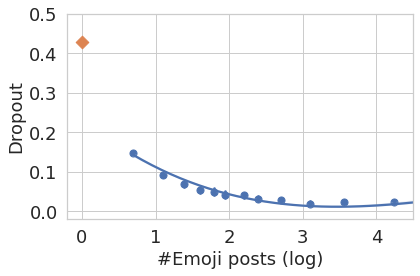

In [113]:
xname = "emoji_post_log"
x_label = xname_label[xname]

ax=sns.regplot(x=xname, y=yname, data=df_active_emoji, order=3, fit_reg=True, x_bins=20)#
ax2=sns.regplot(x=xname, y=yname, data=df_active_non_emoji, fit_reg=False, x_bins=10, marker=u"D", scatter_kws={"s":80})#
plt.xlim(-0.2, 4.5)
plt.ylim(-0.02, 0.5)
plt.xlabel(x_label, fontsize=18)
plt.ylabel(y_label, fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig(f"../visualization/{xname}_vs_{yname}.png", dpi=300)

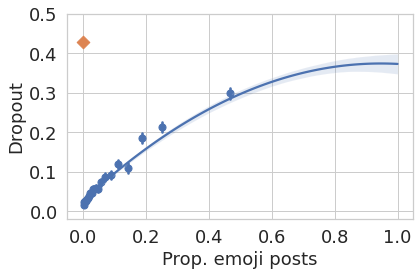

In [114]:
xname = "emoji_post_prop"
x_label = xname_label[xname]

ax = sns.regplot(x=xname, y=yname, data=df_active_emoji, order=2, fit_reg=True, x_bins=20)#
ax2 = sns.regplot(x=xname, y=yname, data=df_active_non_emoji, fit_reg=False, x_bins=10, marker=u"D", scatter_kws={"s":80})#
plt.ylim(-0.02, 0.5)
plt.xlabel(x_label, fontsize=18)
plt.ylabel(y_label, fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig(f"../visualization/{xname}_vs_{yname}.png", dpi=300)

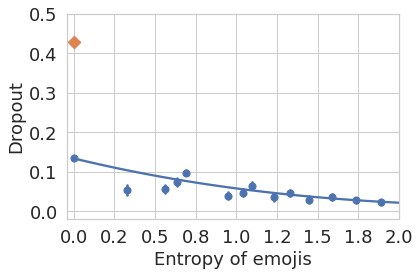

In [115]:
xname="emoji_entropy"
x_label=xname_label[xname]

ax=sns.regplot(x=xname, y=yname, data=df_active_emoji, order=3, fit_reg=True, x_bins =30)#
ax2=sns.regplot(x=xname, y=yname, data=df_active_non_emoji, fit_reg=False, x_bins=10, marker=u"D", scatter_kws={"s":80})#
plt.xlim(-0.04, 2)
plt.ylim(-0.02, 0.5)
plt.xlabel(x_label, fontsize=18)
ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
plt.ylabel(y_label, fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig(f"../visualization/{xname}_vs_{yname}.jpg", dpi=300)

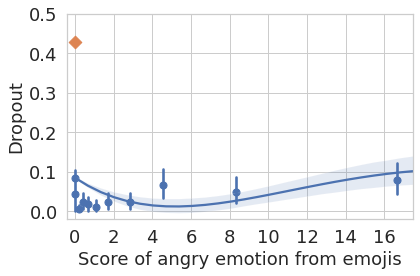

In [116]:
xname="anger"
x_label=xname_label[xname]

ax=sns.regplot(x=xname, y=yname, data=df_active_emoji, order=5, fit_reg=True, x_bins=400)#
ax2=sns.regplot(x=xname, y=yname, data=df_active_non_emoji, fit_reg=False, x_bins=10, marker=u"D", scatter_kws={"s":80})#
plt.xlim(-0.4, 17.5)
plt.ylim(-0.02, 0.5)
plt.xlabel(x_label, fontsize=18)
plt.ylabel(y_label, fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig(f"../visualization/{xname}_vs_{yname}.png", dpi=300)

### 3.3.3 Dropout ratio vs. programming languages

In [117]:
df_lang = pd.read_csv(f"{data_dir}/lang_emoji_dropout", sep ="\t", header=0)
df_lang

,idx,lang,dropout,dropout_in_emoji,dropout_in_non_emoji
0,0,JavaScript,0.411352,0.102581,0.437118
1,1,Python,0.417603,0.105775,0.435947
2,2,Java,0.422875,0.129118,0.434839
3,3,C++,0.494670,0.117690,0.512313
4,4,Go,0.336352,0.068713,0.365958
5,5,HTML,0.430102,0.148910,0.447343
6,6,PHP,0.411044,0.111136,0.432735
7,7,Ruby,0.359160,0.106063,0.396035
8,8,TypeScript,0.368674,0.087882,0.399523
9,9,C#,0.446148,0.150743,0.463463


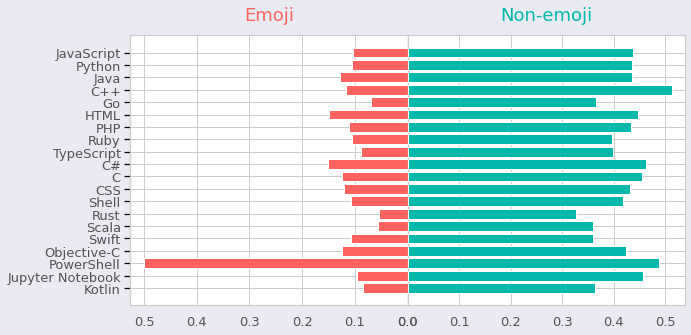

In [118]:
font_color = "#525252"
facecolor = "#eaeaf2"
color_red = "#fd625e"
color_blue = "#01b8aa"
index = df_lang.index
column0 = df_lang["dropout_in_emoji"]
column1 = df_lang["dropout_in_non_emoji"]
title0 = "Emoji"
title1 = "Non-emoji"

fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align="center", color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red)
axes[1].barh(index, column1, align="center", color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue)

# If you have positive numbers and want to invert the x-axis of the left plot
axes[0].invert_xaxis() 

# To show data from highest to lowest
plt.gca().invert_yaxis()

axes[0].set(yticks=df_lang.index, yticklabels=df_lang.lang)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis="y", colors="black") # tick color

# axes[1].set_xticklabels([1000, 2000, 3000, 4000, 5000, 6000, 7000])

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color)

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
plt.savefig("../visualization/lang_emoji_dropout.png", facecolor = facecolor, dpi = 300)